In [1]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs --break-system-packages
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO --break-system-packages

In [2]:
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/objFuncs
# !pip install -e /files/shared/ap/jupyter-notebook/pkgs/pyBO

In [3]:
# !pip install -e ../../objFuncs
# !pip install -e ../../pyBO

# large decision bound was essential!

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from copy import deepcopy as copy

/home/devuser/.local/lib/python3.9/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [5]:
import objFuncs
from objFuncs import VM
from objFuncs import residuals
from objFuncs.util import plot_obj_history, plot_multi_obj_history
from objFuncs import flame_utils_kilean as flame_utils

objFuncs version: 1.0.3. updated on 2024-01-25


In [6]:
from pyBO import pyBO

n_init = 16
batch_size = 2
n_local_search = batch_size
n_loop = 8
budget = n_init+n_loop*batch_size
print(budget)

pyBO version: 1.0.0. updated on 2023-12-14
32


In [7]:
latfile = "../objFuncs/FLAME_lat/test_FS1d_20231130_040841_read.lat"

In [8]:
decision_CSETs=['FS1_CSS:PSC2_D2351', 'FS1_CSS:PSC2_D2367']
decision_min = -20
decision_max =  20

In [9]:
objective_goal = { 
    'FS1_CSS:BPM_D2383:XPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2421:XPOS_RD' : 0.0,
    'FS1_BBS:BPM_D2466:XPOS_RD' : 0.0,
}
objective_norm = {pv:2.0 for pv in objective_goal.keys()}
objective_weight = {pv:1.0 for pv in objective_goal.keys()}
objective_RDs = list(objective_goal.keys())

conditional_SETs = {
    'FS1_CSS:PSQ_D2372:I_CSET':[],
    'FS1_CSS:PSQ_D2377:I_CSET':[],
}

In [10]:
fm_vm = flame_utils.VM(
        latfile = latfile,
        decision_CSETs = list(conditional_SETs.keys()),
        objective_RDs  = objective_RDs,)
fm = fm_vm.fm
fm.zero_orbtrim()

n_condition = len(conditional_SETs)+1

for i,k in enumerate(conditional_SETs.keys()):
    fm_vm.x0[i] = round(fm_vm.x0[i], 2)
    conditional_SETs[k] = [fm_vm.x0[i]]*n_condition
    conditional_SETs[k][i+1] += 20

for k, v in conditional_SETs.items():
    print(k,v)

FS1_CSS:PSQ_D2372:I_CSET [54.38, 74.38, 54.38]
FS1_CSS:PSQ_D2377:I_CSET [36.79, 36.79, 56.79]


In [11]:
Quads = fm.get_df_by_type('quadrupole')
misalign = pd.read_csv('../objFuncs/data/FRIB As-Aligned Component Positions.csv')

new_misalign = []

for name in Quads['name']:
    name_ = name.replace('QH','QV')
    i = misalign[misalign['Name'] == name_].index
    if len(i) == 0:
        name_ = name.replace('QV','QH')
        i = misalign[misalign['Name'] == name_].index
    i = i[0]
    new_misalign.append(misalign.loc[i]) 
    
misalign = pd.DataFrame(new_misalign)
misalign.rename(columns={'Name': 'name'},inplace=True)
misalign.index = Quads.index

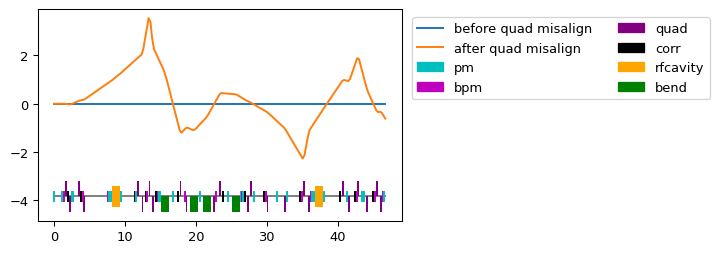

In [12]:
r,s = fm.run(monitor='all')
r0 = fm.collect_data(r,'pos','xcen','ycen','xrms','yrms')

Quads['dx'] = misalign['Horz_Off_Meters'].values
Quads['dy'] = misalign['Vert_Off_Meters'].values
Quads['pitch'] = misalign['Pitch_R1_Deg'].values/180*np.pi
Quads['roll'] = misalign['Roll_R2_Deg'].values/180*np.pi
Quads['yaw'] = misalign['Yaw_R3_Deg'].values/180*np.pi

for i in Quads.index:
    fm.reconfigure(i,{'dx':Quads['dx'].loc[i]})
    fm.reconfigure(i,{'dy':Quads['dy'].loc[i]})
    fm.reconfigure(i,{'pitch':Quads['pitch'].loc[i]})
    fm.reconfigure(i,{'roll':Quads['roll'].loc[i]})
    fm.reconfigure(i,{'yaw':Quads['yaw'].loc[i]})
    
r,s = fm.run(monitor='all')
r1 = fm.collect_data(r,'pos','xcen','ycen','xrms','yrms')

plotlat = flame_utils._plot_lattice(fm.machine)
fig,ax = plt.subplots(figsize=(5,3),dpi=94)
ax.plot(r0['pos'],r0['xcen'],label='before quad misalign')
ax.plot(r0['pos'],r1['xcen'],label='after quad misalign')
ymin,ymax = ax.get_ylim()
plotlat(ax=ax,ymin=ymin,ymax=ymax)

In [13]:
fm_vms = []
for i in range(n_condition):
    fm_vm = flame_utils.VM(
            latfile = latfile,
            decision_CSETs = decision_CSETs,
            objective_RDs  = objective_RDs,
            conditional_SETs = {key:val[i] for key, val in conditional_SETs.items()},
        )
    fm = fm_vm.fm
    fm.zero_orbtrim()
    # add quad misalignment
    for i in Quads.index:
        fm.reconfigure(i,{'dx':Quads['dx'].loc[i]})
#     m0 = copy(fm_vm.fm.bmstate.moment0)
#     m0[0] = 2.
#     fm_vm.fm.bmstate.moment0 = m0
    fm_vms.append(fm_vm)

In [14]:
machineIO_vms = []
for fm_vm in fm_vms:
    machineIO_vms.append(
        VM(
            x0 = fm_vm.x0,
            fun = fm_vm,
            decision_CSETs = decision_CSETs,
            objective_RDs = objective_RDs,
            fetch_data_time_span = 0.2,
        )
    )

In [15]:
BPMnames = [pv.replace(':XPOS_RD','') for pv in objective_RDs]
BPMs = fm.get_df_by_type('bpm')
BPMs = BPMs[BPMs['name'].isin(BPMnames)]
BPMs

,z,name,type,L
index,,,,
82,14.587727,FS1_CSS:BPM_D2383,bpm,0.0
103,18.403514,FS1_BBS:BPM_D2421,bpm,0.0
123,22.884765,FS1_BBS:BPM_D2466,bpm,0.0


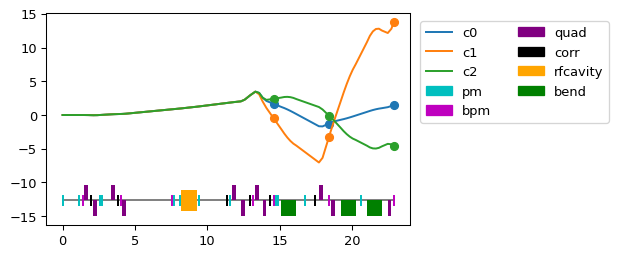

In [16]:
r0 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r0.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
for i,r0_ in enumerate(r0):
    ax.plot(r0_['pos'],r0_['xcen'],label='c'+str(i))
    ax.scatter(r0_['pos'][BPMs.index],r0_['xcen'][BPMs.index])
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

In [17]:
objFuncs._global_machineIO.fetch_data = machineIO_vms[0].fetch_data
objFuncs._global_machineIO.ensure_set = machineIO_vms[0].ensure_set
objFuncs._global_machineIO._test = True

In [18]:
res = residuals.residualObjMultiConditionalVar(  
    decision_CSETs = decision_CSETs,
    decision_min= decision_min,
    decision_max= decision_max,
    objective_goal = objective_goal,
    objective_norm = objective_norm,
    objective_weight = objective_weight,
    conditional_SETs = conditional_SETs,
    var_obj_weight_fraction = 1.0,
    )

for i in range(n_condition):
    res.residualObj[i].machineIO = machineIO_vms[i]

[condition_controller] ======== class info ========
init_time: 2024-02-08 13:48:10.374771
class_hierarchy: [
    objFuncBase]
decision_CSETs: [
    FS1_CSS:PSQ_D2372:I_CSET, FS1_CSS:PSQ_D2377:I_CSET]
decision_min: [54.38 36.79]
decision_max: [74.38 56.79]
decision_bounds: [[54.38 74.38]
 [36.79 56.79]]
decision_RDs: [
    FS1_CSS:PSQ_D2372:I_RD, FS1_CSS:PSQ_D2377:I_RD]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: condition_controler
logging_fname: None
x0: [
    0.5, 0.5]

[condition 0] ======== class info ========
init_time: 2024-02-08 13:48:10.477308
class_hierarchy: [
    residualObj, objFuncBase]
decision_CSETs: [
    FS1_CSS:PSC2_D2351, FS1_CSS:PSC2_D2367]
decision_min: [-20. -20.]
decision_max: [20. 20.]
decision_bounds: [[-20.  20.]
 [-20.  20.]]
decision_RDs: [
    FS1_CSS:PSC2_D2351, FS1_CSS:PSC2_D2367]
decision_tols: None
decision_couplings: None
history_buffer_size: None
logging_frequency: inf
logging_tag: .residu

In [19]:
plot_decisions = plot_obj_history(
    res.history['decision_RDs'],
    title='decision_RDs',
)

plot_control = plot_obj_history(
    res.condition_controller.history['decision_CSETs'],
    title='condition controller',
)

plot_conditions_RDs = plot_multi_obj_history(
    histories = [res.history['condition'+str(i)]['objective_RDs'] for i in range(n_condition)],
    history_labels = ['C'+str(i) for i in range(n_condition)],
    title='multi-condition_obj_RDs',
)
plot_objectives_var = plot_obj_history(
    res.history['objectives_var'],
    title='objectives_var',
)

class add_delay:
    def __init__(self):
        pass
    def __call__(self):
        time.sleep(0.01)
    def close(self):
        pass
    
add_delay = add_delay()
    
callbacks = [add_delay,plot_decisions,plot_control,plot_conditions_RDs,plot_objectives_var,add_delay]
# callbacks = []

In [20]:
def func_obj(x,callbacks=callbacks):
    if x.ndim == 2:
        multi_batch = True
    else:
        multi_batch = False
    obsvars = res(x,multi_batch=multi_batch,callbacks=callbacks)
    if multi_batch:
        return 1-np.mean(obsvars**2,axis=1)
    else:
        return 1-np.mean(obsvars**2)

# run pyBO

### use only local data

In [21]:
# bo, X_pending, Y_pending_future = pyBO.runBO(
#     func_obj = func_obj,
#     bounds=res.decision_bounds,
#     n_init=n_init,
#     budget=n_init+batch_size,
#     isfunc_obj_batched=True,
#     batch_size=batch_size,
#     x0=res.x0,
#     timeout = 2*batch_size,
# )

# size_of_bounds = res.decision_bounds[:,1]-res.decision_bounds[:,0]
# betas = np.linspace(9,0.01,n_loop)
# for i in range(n_loop):
    
#     x_best,y_best = bo.best_sofar()
#     x_local_min = x_best - 0.4*size_of_bounds
#     x_local_max = x_best + 0.4*size_of_bounds

#     n = len(bo.y)
#     x = bo.x
#     y = bo.y
#     mask = np.all(np.logical_and(x > x_best-0.3*size_of_bounds, x < x_best+0.3*size_of_bounds), axis=1)
#     x = x[mask]
#     y = y[mask]
#     print(i, np.sum(mask)/len(mask))

#     local_bounds = list(zip(x_best - 0.25*size_of_bounds, x_best + 0.25*size_of_bounds))
#     print(local_bounds)
    
#     acquisition_func_args = {'beta':betas[i]}
#     bo.update_model(x=x,y=y)
    
#     X_pending, Y_pending_future = bo.loop(
#         n_loop = 1,
#         func_obj = func_obj,
#         isfunc_obj_batched = True,
#         bounds=local_bounds,
#         acquisition_func_args=acquisition_func_args,
#         X_pending = X_pending,
#         Y_pending_future = Y_pending_future,
#         batch_size = batch_size,
#         write_log = False,
#         timeout = 2*batch_size,
#     )
    
# bo.update_model(X_pending=X_pending,
#                 Y_pending_future = Y_pending_future,
#                 )

# for f in callbacks:
#     f.close()

### use all data

scipy version mismatch. 'scipy.stat.qmc' is not imported. Using custom halton seqeunce instead


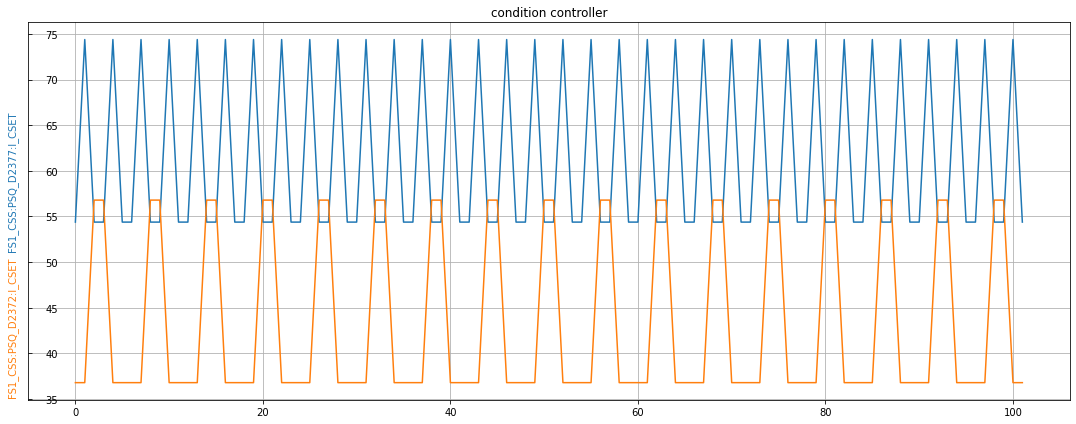

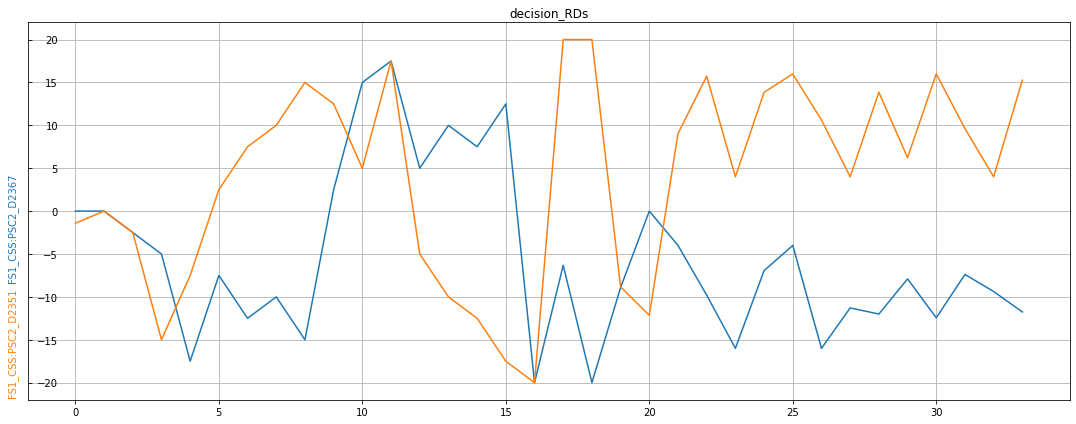

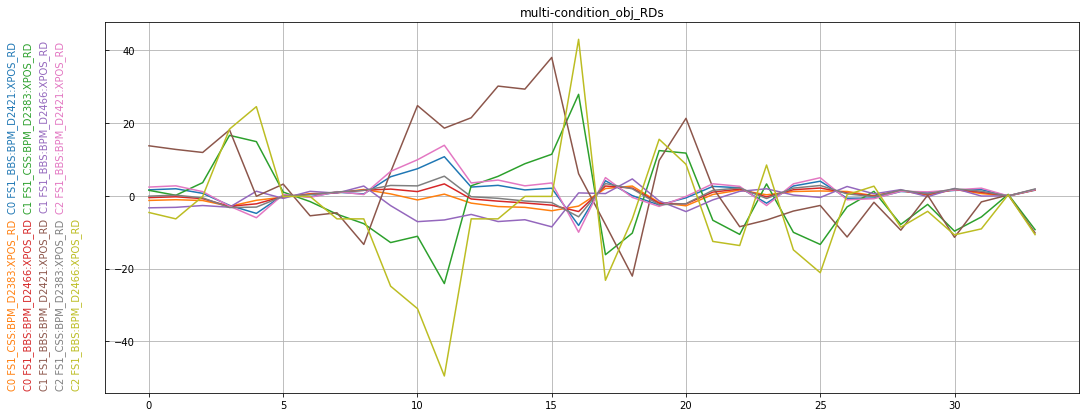

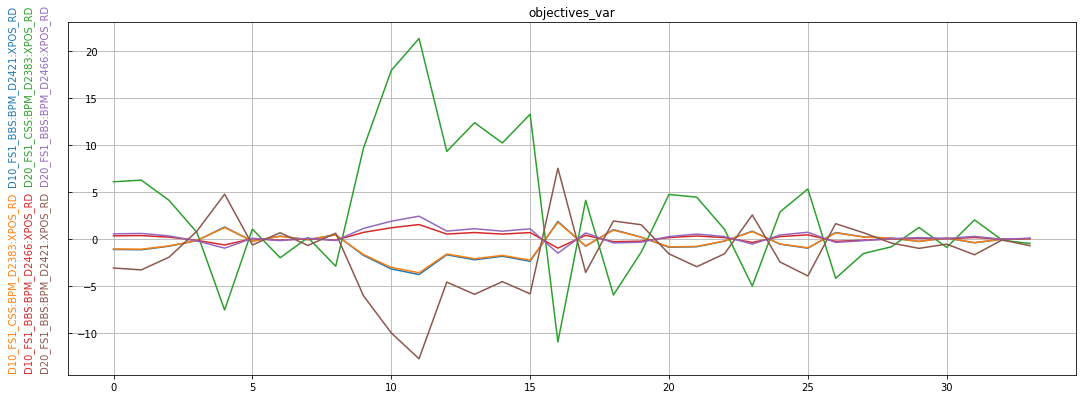

20
22
24
26
28
30


In [22]:
# run optimizer
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    func_obj,  
                                    bounds=res.decision_bounds,
                                    n_init=n_init,
                                    x0 = res.x0,
                                    budget = n_init + 2*n_local_search,
                                    batch_size=1,
                                    timeout = 2*batch_size,
                                    write_log = False)
bounds_diff = res.decision_bounds[:,1] - res.decision_bounds[:,0]


while(len(bo.y)<budget):
    print(len(bo.y))
    x_best,y_best = bo.best_sofar()
    bounds_best = np.array(list(zip(x_best-0.15*bounds_diff, x_best+0.15*bounds_diff)))
    acquisition_func_args = {'beta':9}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=n_local_search-1,  # number of additional optimization interation
                                    func_obj = func_obj,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    
    acquisition_func_args = {'beta':1}

    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=1,  # number of additional optimization interation
                                    func_obj = func_obj,
                                    bounds = bounds_best,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    
x_best,y_best = bo.best_sofar()
bounds_best = np.array(list(zip(x_best-0.15*bounds_diff, x_best+0.15*bounds_diff)))
acquisition_func_args = {'beta':0.01}

X_pending, Y_pending_future= bo.loop( 
                                n_loop=1,  # number of additional optimization interation
                                func_obj = func_obj,
                                bounds = bounds_best,
                                acquisition_func_args = acquisition_func_args,
                                X_pending = X_pending, 
                                Y_pending_future = Y_pending_future,
                                batch_size = 1,
                                write_log = False,
                                )
    
time.sleep(1)
for f in callbacks:
    f.close()

# results

34


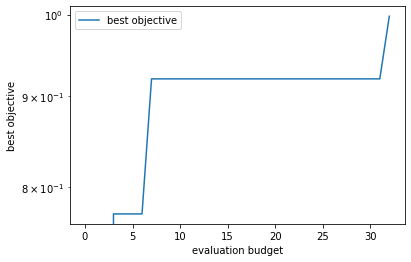

In [23]:
fig,ax = plt.subplots()
bo.plot_obj_history(plot_best_only=True, ax=ax)
ax.legend(loc='upper left')
ax.set_yscale('log')
print(len(res.history['decision_CSETs']['values']))

In [24]:
x_best,y_best_old = bo.best_sofar()
y_best_new = func_obj(x_best,callbacks=None)
print(x_best,y_best_old[0],y_best_new)

[-9.37464153  4.        ] 0.9978695074361317 0.9978695074361317


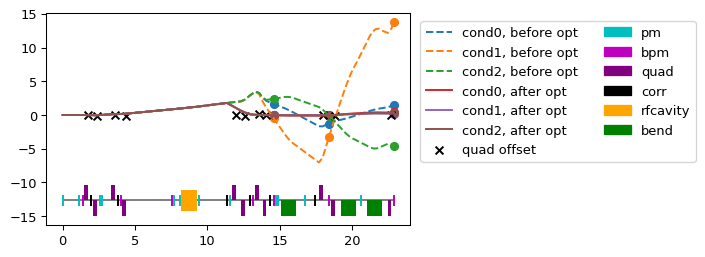

In [25]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],'--',label='cond'+str(i)+', before opt')
    ax.scatter(r0_['pos'][BPMs.index],r0_['xcen'][BPMs.index])
    i+=1
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    ax.scatter(r1_['pos'][BPMs.index],r1_['xcen'][BPMs.index])
    i+=1

ax.scatter(r0_['pos'][Quads.index[:11]],Quads['dx'][:11]*1e3,marker='x',color='k',label='quad offset')
    
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=ax.get_ylim()[0],ymax=ax.get_ylim()[1])

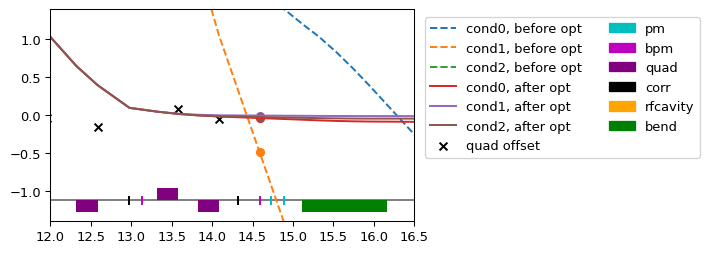

In [26]:
r1 = []
for fm_vm in fm_vms:
    r,s = fm_vm.fm.run(monitor='all',to_element=fm_vm.last_elem_index)
    r1.append( fm_vm.fm.collect_data(r,'pos','xcen','ycen') )

fig,ax = plt.subplots(figsize=(5,3),dpi=94)
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r0_['pos'],r0_['xcen'],'--',label='cond'+str(i)+', before opt')
    ax.scatter(r0_['pos'][BPMs.index],r0_['xcen'][BPMs.index])
    i+=1
i=0
for r0_, r1_ in zip(r0,r1):
    ax.plot(r1_['pos'],r1_['xcen'],label='cond'+str(i)+', after opt')
    ax.scatter(r1_['pos'][BPMs.index],r1_['xcen'][BPMs.index])
    i+=1

ax.scatter(r0_['pos'][Quads.index[:11]],Quads['dx'][:11]*1e3,marker='x',color='k',label='quad offset')
ax.set_xlim(12,16.5)
ax.set_ylim(-1.4,1.4)
    
fm_vm.fm.plot_lattice(end=fm_vm.last_elem_index+1,ax=ax,ymin=-0.8,ymax=0.8)

In [27]:
x_true_opt = np.array([-8.9953826,2.54628931])

[████████████████████████████████████████] 100%/100%

time took:  0.24417365109547973


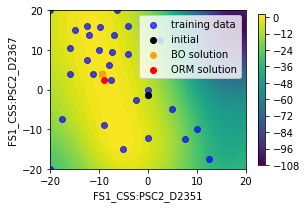

In [28]:
fixed_values_for_each_dim = None

t0 = time.monotonic()
from math import ceil
nplot = int(0.5*len(res.decision_CSETs))
nrow = ceil(0.5*nplot)
fig,ax = plt.subplots(nrow,2,figsize=(8,3*nrow))
for i in range(nrow):
    for j in range(2):
        n = 2*i+j
        if nrow>1:
            ax_ = ax[i,j]
        else:
            ax_ = ax[j]
        if n >= nplot:
            ax_.set_visible(False)
            break
        bo.plot_model_2D_projection(project_maximum=True,
                                    dim_xaxis = 2*n,
                                    dim_yaxis = 2*n+1,
                                    bounds = res.decision_bounds,
                                    grid_ponits_each_dim = 16,
                                    fixed_values_for_each_dim=fixed_values_for_each_dim,
                                            fig=fig,ax=ax_);
        ax_.scatter(res.x0[2*n],res.x0[2*n+1],color='k',label='initial')
        ax_.scatter(x_best[2*n],x_best[2*n+1],color='orange',label='BO solution')
        ax_.scatter(x_true_opt[0],x_true_opt[1],color='r',label='ORM solution')
        ax_.set_xlabel(res.decision_CSETs[2*n  ])
        ax_.set_ylabel(res.decision_CSETs[2*n+1])
        ax_.legend()
fig.tight_layout()

    
print('time took: ',time.monotonic()-t0)

In [29]:
print(x_best)
func_obj(x_best,callbacks=[])

[-9.37464153  4.        ]


0.9978695074361317

In [30]:
func_obj(x_true_opt,callbacks=[])

0.9999984040398133